# Bike Sharing

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import calendar
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
bike = pd.read_csv('day.csv')
bike.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
bike.dtypes

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object

#### Check percentage of columns with null values

In [6]:
bike.isna().mean() * 100

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

# Drop unnecessary columns

In [8]:
bike.drop('instant', axis=1, inplace=True)
bike = bike.drop('dteday', axis=1)

In [9]:
# casual and registered are not features
bike.drop(['casual', 'registered'], axis = 1, inplace=True)

In [10]:
#map month number to name for better EDA analysis
bike['mnth'] = bike['mnth'].apply(lambda x : calendar.month_name[x])

In [11]:
#map weeknumber number to name for better EDA analysis
bike['weekday'] = bike['weekday'].apply(lambda x : calendar.day_name[x])
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,January,0,Sunday,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,January,0,Monday,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,January,0,Tuesday,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,January,0,Wednesday,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,January,0,Thursday,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [12]:
# map season number to names
bike['season'] = bike['season'].apply(lambda x : "spring" if x == 1 else "summer" if x == 2 else "fall" if x == 3 else "winter" ).astype(object) 

In [13]:
# map weathersit number to names
bike['weathersit'] = bike['weathersit'].apply(lambda x : "Clear, Few clouds, Partly cloudy, Partly cloudy" if x == 1 else "Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist" if x == 2 else "Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds" if x == 3 else "Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog" ).astype(object) 

In [14]:
bike.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


In [15]:
bike.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,0.500000,0.028767,0.683562,20.319259,23.726322,62.765175,12.763620,4508.006849
std,0.500343,0.167266,0.465405,7.506729,8.150308,14.237589,5.195841,1936.011647
min,0.000000,0.000000,0.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,0.000000,0.000000,0.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,0.500000,0.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,1.000000,0.000000,1.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,1.000000,1.000000,1.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


# Univariate Analysis

In [17]:
#segregating categorical and continuous variables
categorical_vars = ['season', 'yr', 'mnth', 'weekday', 'workingday', 'weathersit']
continuous_vars = ['atemp', 'hum', 'windspeed', 'temp'] #not adding 'cnt' here

#### Univariate analysis for continuous variables

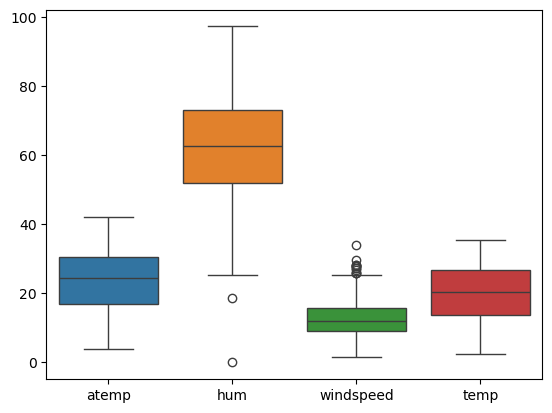

In [19]:
sns.boxplot(bike[continuous_vars])
plt.show()

#### Univariate analysis for categorical variables

<Figure size 1000x10000 with 0 Axes>

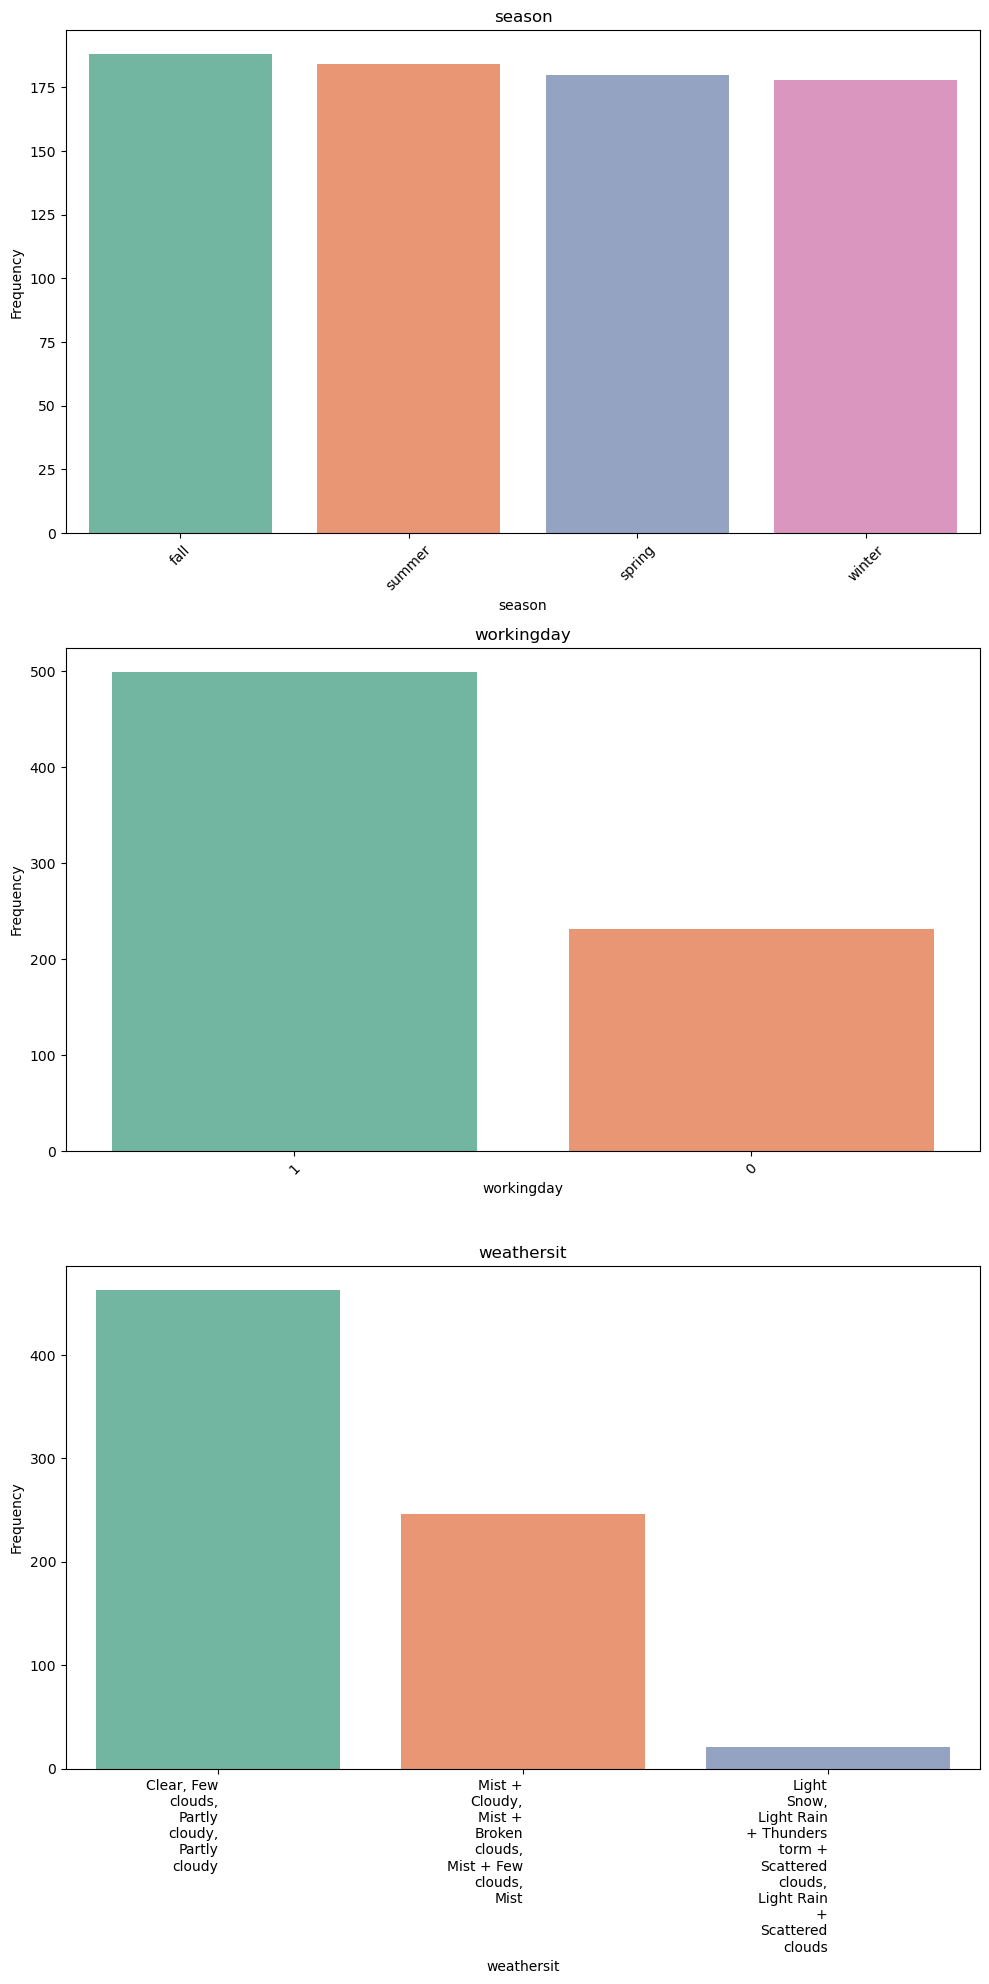

In [21]:
import textwrap
plt.figure(figsize=(10, 100))

categorical_vars= ['season', 'workingday', 'weathersit']
fig, axs = plt.subplots( len(categorical_vars), 1, figsize=(10, 20))

# Loop through the columns and plot on each subplot
for index, col in enumerate(categorical_vars):
    # Plot the bar chart
    ax = sns.countplot(data=bike, x=col,  palette="Set2", ax=axs[index], order=bike[col].value_counts().index)
    labels = [textwrap.fill(label.get_text(), 10) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=45) 
    axs[index].set_title(col) 
    axs[index].set_ylabel('Frequency') 
    
# Adjust the layout to avoid overlap of subplots
plt.tight_layout()
plt.xticks(rotation=0, ha='right')

plt.show()


#### Conclusion
1. Most bikes rented on weekdays
2. Most bikes rented on Clear, Few clouds, Partly cloudy, Partly cloudy days

# Bivariate Analysis

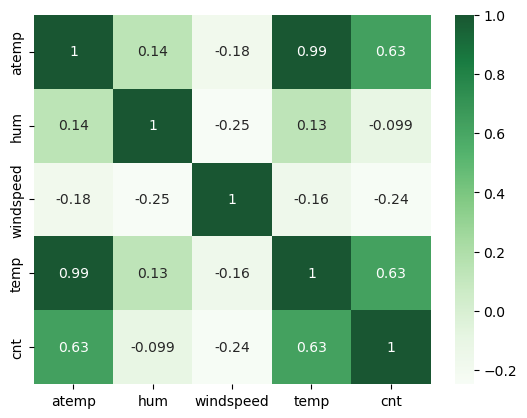

In [24]:
df_filtered= bike[['atemp', 'hum', 'windspeed', 'temp', 'cnt']].corr()
sns.heatmap(df_filtered, cmap="Greens", annot=True, alpha=0.9)
plt.show()

In [25]:
#Since atemp and temp has high correlation, dropping of temp
bike.drop('temp', axis=1, inplace=True)

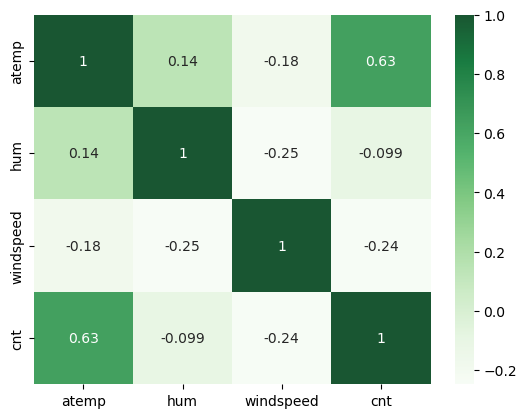

In [26]:
continuous_vars = ['atemp', 'hum', 'windspeed', 'cnt']
df_filtered= bike[continuous_vars].corr()
sns.heatmap(df_filtered, cmap="Greens", annot=True, alpha=0.9)
plt.show()

In [27]:
bike.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,spring,0,January,0,Sunday,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",18.18125,80.5833,10.749882,985
1,spring,0,January,0,Monday,0,"Mist + Cloudy, Mist + Broken clouds, Mist + Fe...",17.68695,69.6087,16.652113,801
2,spring,0,January,0,Tuesday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",9.47025,43.7273,16.636703,1349
3,spring,0,January,0,Wednesday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",10.60610,59.0435,10.739832,1562
4,spring,0,January,0,Thursday,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",11.46350,43.6957,12.522300,1600


#### Bivariate analysis for categorical variables

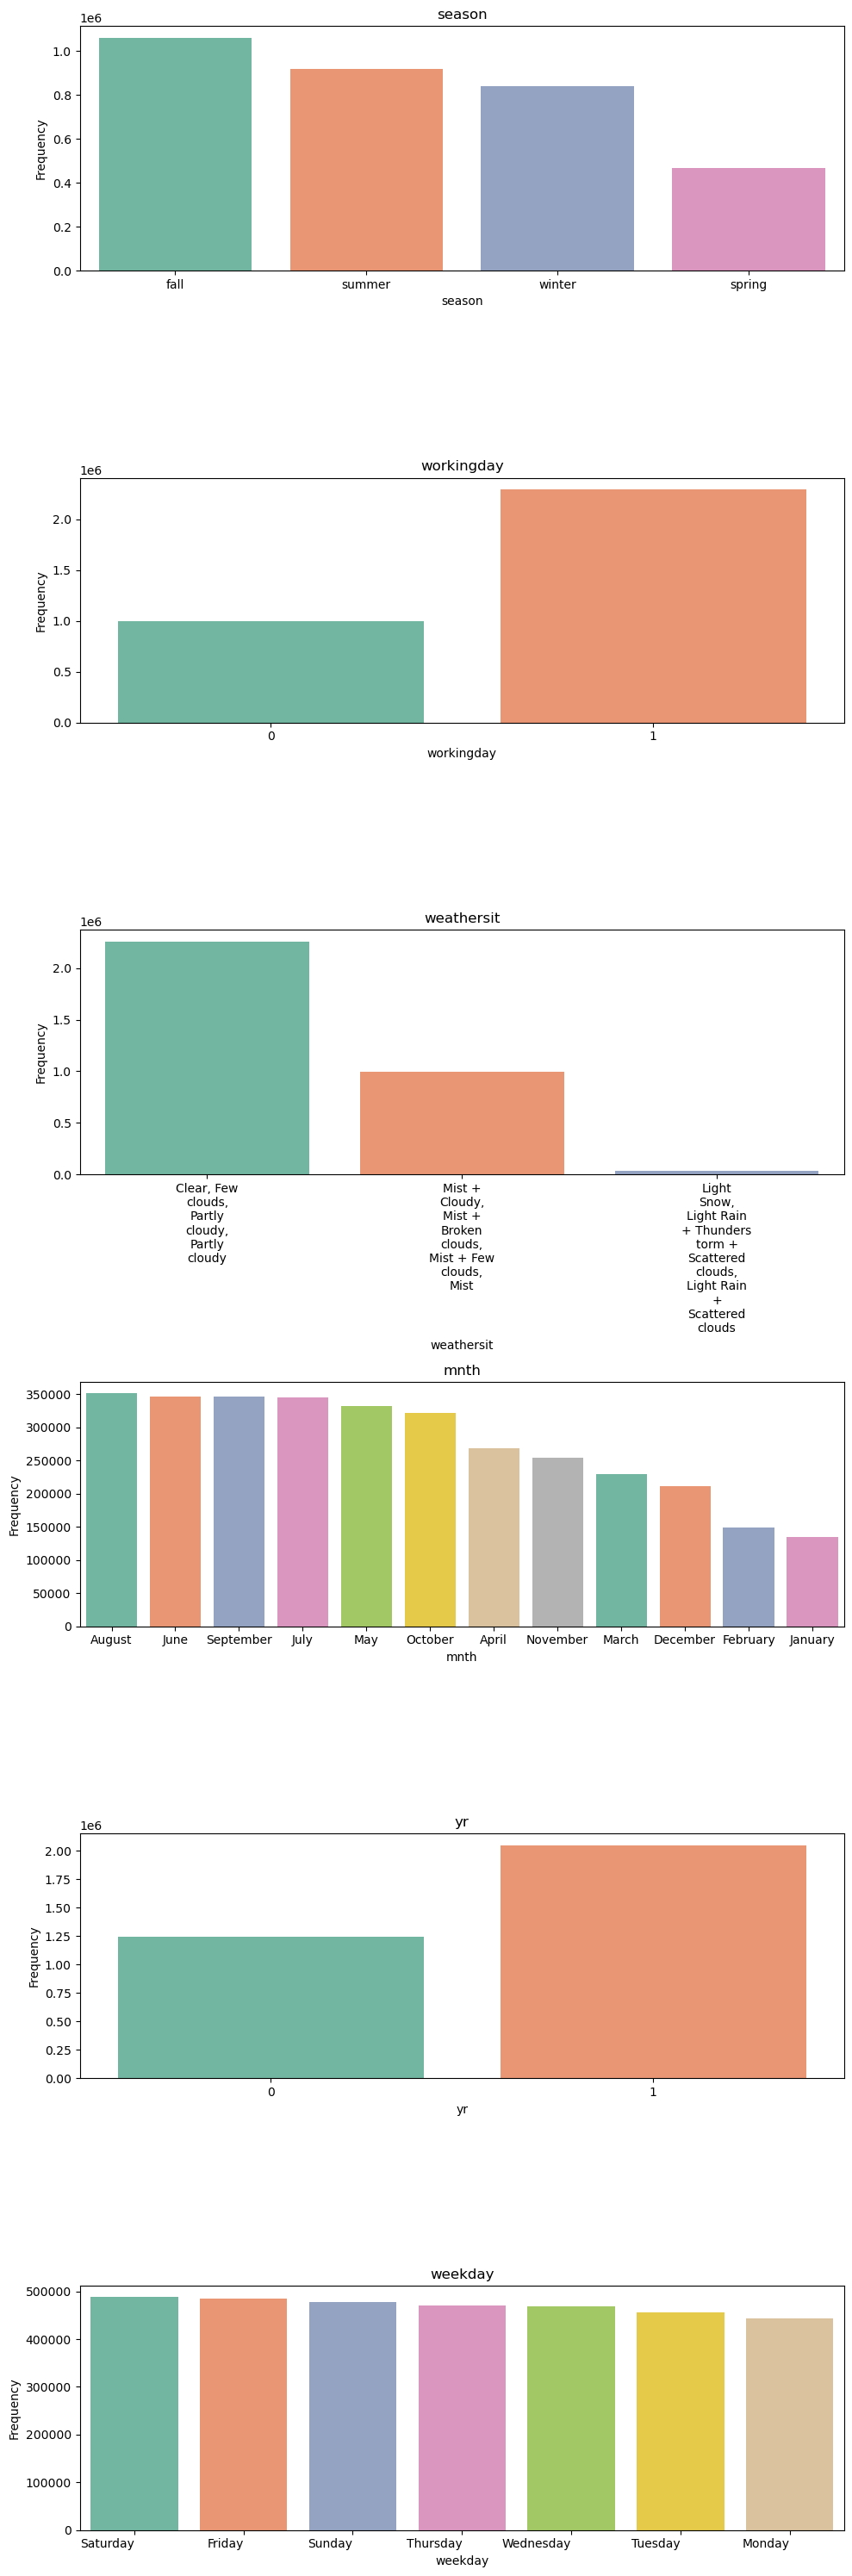

In [29]:
import textwrap
categorical_vars= ['season', 'workingday', 'weathersit', 'mnth', 'yr', 'weekday']
fig, axs = plt.subplots( len(categorical_vars), 1, figsize=(10, 30))

# Loop through the columns and plot on each subplot
for index, col in enumerate(categorical_vars):
    # Group data by 'col' and sum 'cnt'
    grouped_data = bike.groupby(col, as_index=False)['cnt'].sum().sort_values(by='cnt', ascending=False)
    # Plot the bar chart
    ax = sns.barplot(data=grouped_data, x=col, y='cnt', palette="Set2", ax=axs[index])
    labels = [textwrap.fill(label.get_text(), 10) for label in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=0) 
    axs[index].set_title(col) 
    axs[index].set_ylabel('Frequency') 
    
# Adjust the layout to avoid overlap of subplots
plt.tight_layout()
plt.xticks(rotation=0, ha='right')

plt.show()


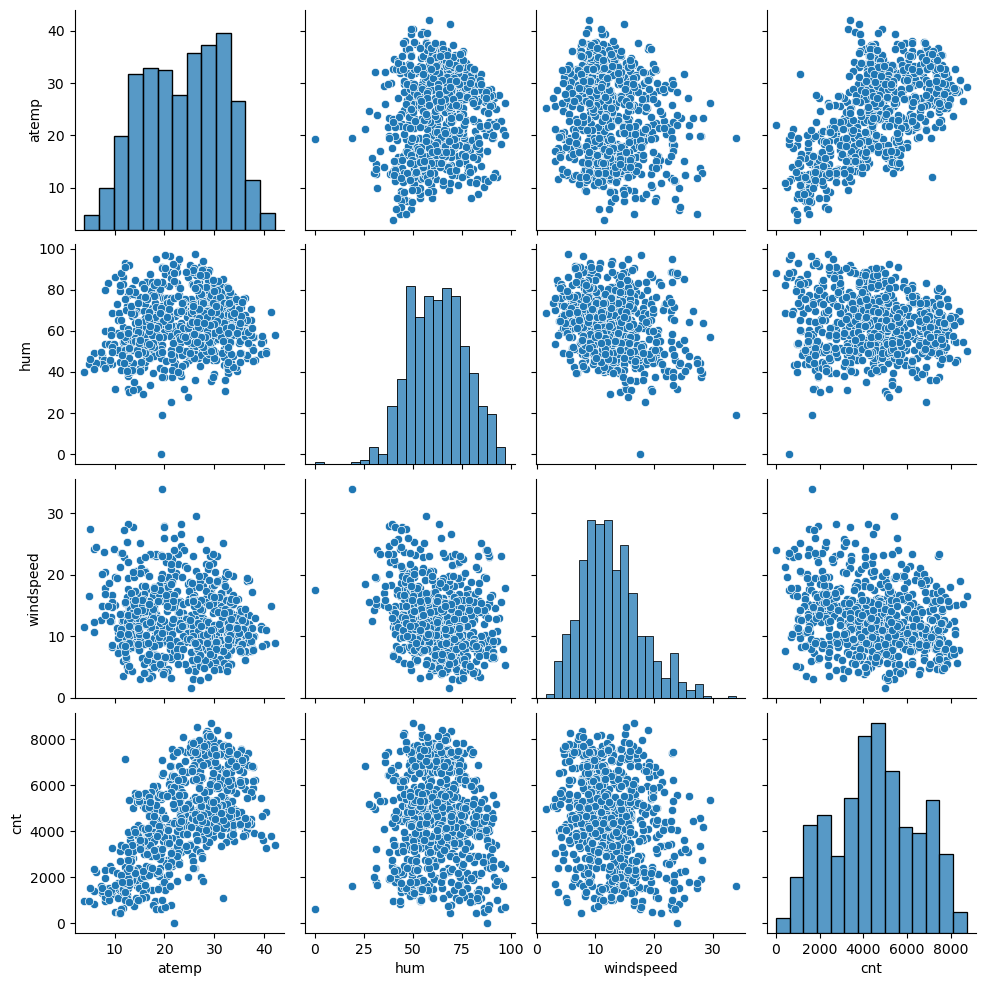

In [30]:
sns.pairplot(bike[continuous_vars])

#### Conclusion

1. Most bikes are rented in Fall season, on working day 
2. Most bikes are rented in the month of June - September
3. Most bikes are rented in working day
4. Most bikes are rented in 2019

# Create Dummies

In [33]:
categorical_varaibles = ['season', 'weathersit', 'mnth', 'weekday']
filteres_data = bike[categorical_varaibles]
dummies_data = pd.get_dummies(filteres_data, drop_first= True).astype(int)
dummies_data.head()

,season_spring,season_summer,season_winter,"weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds","weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist",mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,...,mnth_May,mnth_November,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
#Drop actual columns from dataframe and concat dummies created in previous step
bike.drop(['season', 'weathersit', 'mnth', 'weekday'], axis=1, inplace=True)
bike = pd.concat([bike, dummies_data], axis=1)

## 3. Model Building and Evaluation

In [36]:
# Split the dataframe into train and test sets
df_train, df_test = train_test_split(bike, train_size=0.7, random_state=100)

In [37]:
bike.columns

Index(['yr', 'holiday', 'workingday', 'atemp', 'hum', 'windspeed', 'cnt',
       'season_spring', 'season_summer', 'season_winter',
       'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January',
       'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November',
       'mnth_October', 'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday'],
      dtype='object')

In [38]:
# Import the StandardScaler()
from sklearn.preprocessing import MinMaxScaler

# Create a scaling object
scaler = MinMaxScaler()

# Create a list of the variables that you need to scale
varlist = ['atemp', 'hum', 'windspeed']

# Scale these variables using 'fit_transform'
df_train[varlist] = scaler.fit_transform(df_train[varlist])

In [39]:
df_train.head()

,yr,holiday,workingday,atemp,hum,windspeed,cnt,season_spring,season_summer,season_winter,...,mnth_May,mnth_November,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
576,1,0,1,0.766351,0.725633,0.264686,7216,0,0,0,...,0,0,0,0,0,0,0,0,0,1
426,1,0,0,0.438975,0.640189,0.255342,4066,1,0,0,...,0,0,0,0,0,0,1,0,0,0
728,1,0,0,0.200348,0.498067,0.663106,1796,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.391735,0.504508,0.188475,4220,0,1,0,...,0,0,0,0,0,0,1,0,0,0
111,0,0,1,0.318819,0.751824,0.380981,1683,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [40]:
# Split the train dataset into X and y
y_train = df_train.pop('cnt')
X_train = df_train

### Building the first model with all the features


In [42]:
X_train_sm = sm.add_constant(X_train)

In [43]:
lm = sm.OLS(y_train, X_train_sm).fit()

In [44]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     101.4
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.07e-179
Time:                        07:28:03   Log-Likelihood:                -4102.6
No. Observations:                 510   AIC:                             8261.
Df Residuals:                     482   BIC:                             8380.
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                               2226.5340    306.222      7.271      0.000    1624.839    2828.229
yr                                                                                                  2037.3035     70.413     28.934      0.000    1898.949    2175.658
holiday                                                                                              120.2127    208.540      0.576      0.565    -289.548     529.973
workingday                                                                                           808.6254    108.306      7.466      0.000     595.815    1021.436
atemp                                                                                               3616.2560    394.193      9.174      0.000    2841.707    4390.805
hum                                                                                                -1268.2157    337.214     -3.761      0.000   -1930.808    -605.624
windspeed                                                                                          -1463.1301    225.499     -6.488      0.000   -1906.212   -1020.048
season_spring                                                                                       -451.3037    261.814     -1.724      0.085    -965.742      63.135
season_summer                                                                                        302.6216    227.990      1.327      0.185    -145.356     750.599
season_winter                                                                                        882.2864    244.260      3.612      0.000     402.340    1362.232
weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds -2199.1468    231.571     -9.497      0.000   -2654.160   -1744.133
weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                             -531.6674     91.194     -5.830      0.000    -710.854    -352.481
mnth_August                                                                                          364.0112    289.638      1.257      0.209    -205.098     933.120
mnth_December                                                                                       -457.3409    293.247     -1.560      0.120   -1033.542     118.860
mnth_February                                                                                       -350.8649    287.319     -1.221      0.223    -915.418     213.689
mnth_January                                                                 

#### Removing features using RFE

In [46]:
lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(estimator=lm, n_features_to_select=22)
rfe = rfe.fit(X_train, y_train)

col = X_train.columns[rfe.support_]
X_train_rfe = X_train[col]

X_train_sm = sm.add_constant(X_train_rfe)
lm = sm.OLS(y_train, X_train_sm).fit()

In [47]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.2
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          2.04e-185
Time:                        07:28:03   Log-Likelihood:                -4103.8
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     488   BIC:                             8345.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                               2218.9161    265.073      8.371      0.000    1698.091    2739.741
yr                                                                                                  2037.9376     70.010     29.109      0.000    1900.379    2175.496
holiday                                                                                              144.0073    199.668      0.721      0.471    -248.308     536.323
workingday                                                                                           813.5440     87.326      9.316      0.000     641.963     985.125
atemp                                                                                               3517.3233    355.789      9.886      0.000    2818.255    4216.391
hum                                                                                                -1258.0353    331.828     -3.791      0.000   -1910.023    -606.047
windspeed                                                                                          -1459.4081    223.751     -6.522      0.000   -1899.042   -1019.774
season_spring                                                                                       -386.5473    196.195     -1.970      0.049    -772.039      -1.056
season_summer                                                                                        350.2824    159.779      2.192      0.029      36.342     664.222
season_winter                                                                                        986.8636    160.748      6.139      0.000     671.021    1302.706
weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds -2195.3543    229.666     -9.559      0.000   -2646.611   -1744.097
weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                             -526.8733     90.490     -5.822      0.000    -704.671    -349.076
mnth_August                                                                                          454.9106    154.698      2.941      0.003     150.954     758.868
mnth_December                                                                                       -497.4063    158.874     -3.131      0.002    -809.569    -185.244
mnth_February                                                                                       -375.8676    187.644     -2.003      0.046    -744.557      -7.178
mnth_January                                                                 

##### Calculating VIF

In [49]:
vif = pd.DataFrame()
vif['Features'] = X_train_rfe.columns
vif['VIF'] = [variance_inflation_factor(X_train_rfe.values, i) for i in range(X_train_rfe.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,workingday,61.21
20,weekday_Sunday,14.63
19,weekday_Monday,13.83
6,season_spring,6.05
3,atemp,4.87
8,season_winter,4.11
7,season_summer,4.06
1,holiday,3.55
14,mnth_January,2.39
4,hum,2.00


In [50]:
#Calculating rank of features
list(zip(X_train_rfe.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('atemp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
  True,
  1),
 ('weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
  True,
  1),
 ('mnth_August', True, 1),
 ('mnth_December', True, 1),
 ('mnth_February', True, 1),
 ('mnth_January', True, 1),
 ('mnth_June', False, 4),
 ('mnth_May', True, 1),
 ('mnth_November', False, 7),
 ('mnth_September', True, 1),
 ('weekday_Monday', True, 1),
 ('weekday_Sunday', False, 5),
 ('weekday_Tuesday', True, 1)]

#### Removing variable with high p value and low VIF


###### removing holiday

In [53]:
X_train = X_train_rfe.drop('holiday', axis=1)

#Train model again on remaining columns and compare r-squared and adjusted r-squared
X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_sm).fit()
print(lm.summary())

#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.2
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          2.04e-185
Time:                        07:28:03   Log-Likelihood:                -4103.8
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     488   BIC:                             8345.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

***NOTE - After removing holiday although r-squared and adjusted r-squared is not changing but it is reducing the r-squared on test set leading to overfitting. Hence not removing it.***

##### removing weekday_Monday


In [56]:
X_train_weekday_Monday = X_train.drop('weekday_Monday', axis=1)

#Train model again on remaining columns and compare r-squared and adjusted r-squared
X_train_sm = sm.add_constant(X_train_weekday_Monday)
lm = sm.OLS(y_train, X_train_sm).fit()
print(lm.summary())

#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     137.8
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          2.84e-186
Time:                        07:28:03   Log-Likelihood:                -4104.4
No. Observations:                 510   AIC:                             8251.
Df Residuals:                     489   BIC:                             8340.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

***NOTE -  Dropping weekday_Monday reduces rsquared hence keeping it***

In [58]:
#removing hum  
X_train_temp = X_train.drop('hum', axis=1)
X_train_sm = sm.add_constant(X_train_temp)
lm = sm.OLS(y_train, X_train_sm).fit()
print(lm.summary())

#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_temp.columns
vif['VIF'] = [variance_inflation_factor(X_train_temp.values, i) for i in range(X_train_temp.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     133.4
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          1.97e-183
Time:                        07:28:03   Log-Likelihood:                -4111.2
No. Observations:                 510   AIC:                             8264.
Df Residuals:                     489   BIC:                             8353.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

***NOTE - Since removing "hum" reduced rsquared and adjusted rsquared hence keeping it***

#### Removing variable with high VIF and low p value

In [61]:
#removing atemp
X_train_temp = X_train.drop('atemp', axis=1)
X_train_sm = sm.add_constant(X_train_temp)
lm = sm.OLS(y_train, X_train_sm).fit()
print(lm.summary())

#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_temp.columns
vif['VIF'] = [variance_inflation_factor(X_train_temp.values, i) for i in range(X_train_temp.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
print(vif)


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     111.0
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          3.00e-167
Time:                        07:28:04   Log-Likelihood:                -4150.4
No. Observations:                 510   AIC:                             8343.
Df Residuals:                     489   BIC:                             8432.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------

***NOTE - Since removing "atemp" reduced rsquared and adjusted rsquared hence keeping it***

# Final Model

In [64]:
X_train.columns

Index(['yr', 'workingday', 'atemp', 'hum', 'windspeed', 'season_spring',
       'season_summer', 'season_winter',
       'weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
       'weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
       'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January',
       'mnth_June', 'mnth_May', 'mnth_November', 'mnth_September',
       'weekday_Monday', 'weekday_Sunday', 'weekday_Tuesday'],
      dtype='object')

In [65]:
#removing atemp
X_train_sm = sm.add_constant(X_train)
lm = sm.OLS(y_train, X_train_sm).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     131.2
Date:                Tue, 25 Feb 2025   Prob (F-statistic):          2.04e-185
Time:                        07:28:04   Log-Likelihood:                -4103.8
No. Observations:                 510   AIC:                             8252.
Df Residuals:                     488   BIC:                             8345.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================================================
                                                                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
const                                                                                               2362.9234    403.837      5.851      0.000    1569.450    3156.397
yr                                                                                                  2037.9376     70.010     29.109      0.000    1900.379    2175.496
workingday                                                                                           669.5367    230.633      2.903      0.004     216.380    1122.693
atemp                                                                                               3517.3233    355.789      9.886      0.000    2818.255    4216.391
hum                                                                                                -1258.0353    331.828     -3.791      0.000   -1910.023    -606.047
windspeed                                                                                          -1459.4081    223.751     -6.522      0.000   -1899.042   -1019.774
season_spring                                                                                       -386.5473    196.195     -1.970      0.049    -772.039      -1.056
season_summer                                                                                        350.2824    159.779      2.192      0.029      36.342     664.222
season_winter                                                                                        986.8636    160.748      6.139      0.000     671.021    1302.706
weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds -2195.3543    229.666     -9.559      0.000   -2646.611   -1744.097
weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist                             -526.8733     90.490     -5.822      0.000    -704.671    -349.076
mnth_August                                                                                          454.9106    154.698      2.941      0.003     150.954     758.868
mnth_December                                                                                       -497.4063    158.874     -3.131      0.002    -809.569    -185.244
mnth_February                                                                                       -375.8676    187.644     -2.003      0.046    -744.557      -7.178
mnth_January                                                                                        -665.1080    186.660     -3.563      0.000   -1031.865    -298.351
mnth_June                                                                    

In [66]:
#Calculate VIF
vif = pd.DataFrame()
vif['Features'] = X_train_temp.columns
vif['VIF'] = [variance_inflation_factor(X_train_temp.values, i) for i in range(X_train_temp.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,hum,24.11
1,workingday,16.25
4,season_spring,5.29
3,windspeed,4.93
18,weekday_Sunday,4.65
17,weekday_Monday,4.52
6,season_winter,4.09
5,season_summer,3.67
12,mnth_January,2.17
8,"weathersit_Mist + Cloudy, Mist + Broken clouds...",2.07


In [67]:
#Calculate rank of features
list(zip(X_train_temp.columns,rfe.support_,rfe.ranking_))

[('yr', True, 1),
 ('workingday', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_summer', True, 1),
 ('season_winter', True, 1),
 ('weathersit_Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
  True,
  1),
 ('weathersit_Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist',
  True,
  1),
 ('mnth_August', True, 1),
 ('mnth_December', True, 1),
 ('mnth_February', True, 1),
 ('mnth_January', True, 1),
 ('mnth_June', True, 1),
 ('mnth_May', True, 1),
 ('mnth_November', False, 4),
 ('mnth_September', True, 1),
 ('weekday_Monday', False, 7),
 ('weekday_Sunday', True, 1),
 ('weekday_Tuesday', True, 1)]

## Residual Analysis

In [69]:
y_train_pred = lm.predict(X_train_sm)

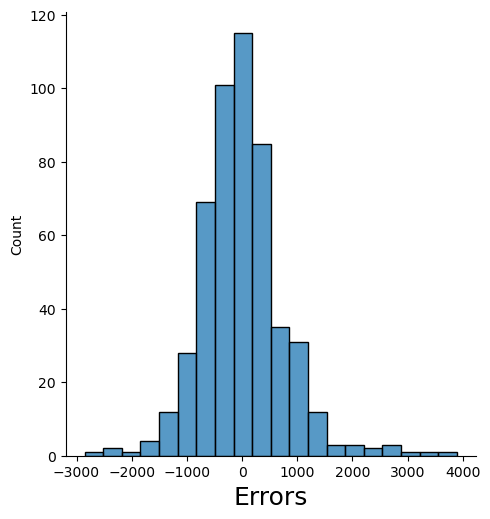

In [70]:
res = y_train_pred - y_train
sns.displot(res, bins=20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)  
plt.show()

***Conclusion -  Error terms are normally distributed***

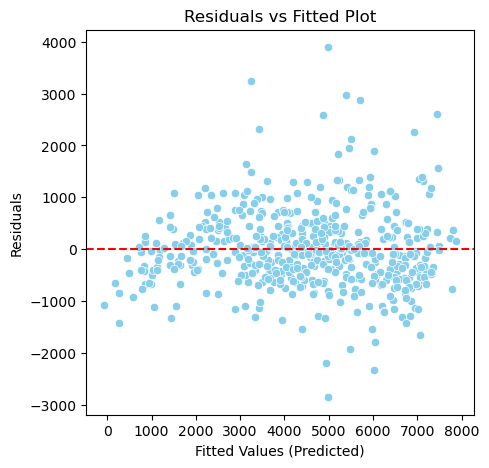

In [72]:
# plot residuals vs fitted

plt.figure(figsize=(5, 5))
sns.scatterplot(x=y_train_pred, y=res, color='skyblue')
plt.axhline(y=0, color='red', linestyle='dashed')  # Reference line at zero
plt.xlabel("Fitted Values (Predicted)")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Plot")
plt.show()

***Conclusion -  Error terms have constant variance***

# Making Prediction

In [75]:
df_test[varlist] = scaler.transform(df_test[varlist])

In [76]:
#Dividing into X_test and y_test
y_test = df_test.pop('cnt')
X_test = df_test

In [77]:
# Creating X_test_new dataframe by dropping variables from X_test
X_test_new = X_test[X_train.columns]

In [78]:
print(len(X_train_rfe.columns))
print(len(X_test_new.columns))

22
21


In [79]:
# Adding a constant variable 
X_test_new = sm.add_constant(X_test_new)

In [80]:
y_test_pred = lm.predict(X_test_new)

In [81]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.8323785298014788

***r2_score on test dataset is coming out to be 0.83***

# Model evaluation

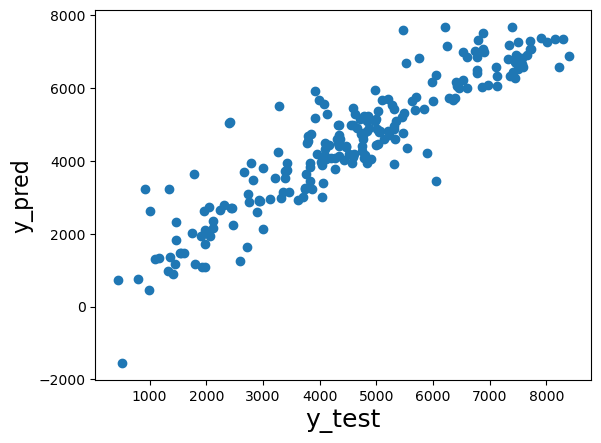

In [84]:
# Plotting y_test and y_pred to understand the spread.
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_pred', fontsize=20)              # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_pred', fontsize=16)                          # Y-label
plt.show()

# Conclusion

Following are the highest impacting variables
1. atemp
2. yr
3. season_winter

Validation of assumptions of simple linear regression :
1. Based on the analysis of residuals error terms are normally distributed 
2. Error terms have constant variance

r-squared on training set is 0.85 and on the test set it's 0.83

There are 22 paramters considered for training.